# 1. Imports & Display Utilities

In [2]:
# Cell 1: imports
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from shapely.geometry import Polygon, MultiPolygon, box
import detectree as dtr
from trace_viewer.trace import TraceCreator

# Utility for inline display
def show_imgs(img_list, titles=None, figsize=(12,6), cmap=None):
    n = len(img_list)
    plt.figure(figsize=figsize)
    for i, img in enumerate(img_list):
        ax = plt.subplot(1, n, i+1)
        if img.ndim == 2:
            ax.imshow(img, cmap=cmap or 'gray')
        else:
            ax.imshow(img)
        if titles:
            ax.set_title(titles[i])
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# 2. Extract overlap

In [3]:

def extract_overlap(img_path1, img_path2, out1='overlap_1.png', out2='overlap_2.png', debug=False):
    # Load images
    img1 = cv2.imread(img_path1)
    img2 = cv2.imread(img_path2)

    if debug:
        show_imgs([cv2.cvtColor(img1, cv2.COLOR_BGR2RGB),
               cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)],
              titles=["Image 1","Image 2"])

    # Detect ORB keypoints & descriptors
    orb = cv2.ORB_create(5000)
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)

    # Match descriptors
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = sorted(bf.match(des1, des2), key=lambda m: m.distance)[:100]

    if debug:
        match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
        show_imgs([cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB)], titles=["Matches"], figsize=(10,5))

    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2)

    # Compute homography (img1 - img2)
    H, _ = cv2.findHomography(pts1, pts2, cv2.RANSAC, 5.0)

    # Project img1 corners into img2 frame
    h1, w1 = img1.shape[:2]
    corners1 = np.float32([[0,0],[w1,0],[w1,h1],[0,h1]]).reshape(-1,1,2)
    warped = cv2.perspectiveTransform(corners1, H).reshape(-1,2)

    if debug:
        plt.figure(); plt.scatter(warped[:,0], warped[:,1], c='r'); plt.title("Warped corners"); plt.show()

    # Build & clean Shapely polygon for img1 footprint
    raw_poly1 = Polygon(warped)
    if not raw_poly1.is_valid:
        cleaned = raw_poly1.buffer(0)
        if isinstance(cleaned, MultiPolygon):
            # keep the largest piece
            raw_poly1 = max(cleaned, key=lambda p: p.area)
        else:
            raw_poly1 = cleaned

    # Define img2 full-frame polygon & intersect
    poly2 = box(0, 0, img2.shape[1], img2.shape[0])
    overlap = raw_poly1.intersection(poly2)
    if overlap.is_empty:
        print("No overlapping region found.")
        return
    if debug:
        x,y = overlap.exterior.xy
        plt.figure(); plt.plot(x,y); plt.title("Overlap Polygon"); plt.show()

    # Crop overlap from img2
    pil2 = Image.open(img_path2).convert("RGBA")
    coords2 = [(int(x), int(y)) for x, y in overlap.exterior.coords]
    mask2 = Image.new('L', pil2.size, 0)
    ImageDraw.Draw(mask2).polygon(coords2, outline=1, fill=255)
    canvas2 = Image.new('RGBA', pil2.size)
    canvas2.paste(pil2, mask=mask2)
    crop2 = canvas2.crop(mask2.getbbox())

    # Crop overlap from img1 via inverse homography
    inv_H = np.linalg.inv(H)
    pts_overlap = np.float32(overlap.exterior.coords).reshape(-1,1,2)
    warped_back = cv2.perspectiveTransform(pts_overlap, inv_H).reshape(-1,2)
    coords1 = [(int(x), int(y)) for x, y in warped_back]
    pil1 = Image.open(img_path1).convert("RGBA")
    mask1 = Image.new('L', pil1.size, 0)
    ImageDraw.Draw(mask1).polygon(coords1, outline=1, fill=255)
    canvas1 = Image.new('RGBA', pil1.size)
    canvas1.paste(pil1, mask=mask1)
    crop1 = canvas1.crop(mask1.getbbox())

    # Compute common dimensions & pad crops
    w_common = max(crop1.width, crop2.width)
    h_common = max(crop1.height, crop2.height)

    final1 = Image.new('RGBA', (w_common, h_common), (0,0,0,0))
    final1.paste(crop1, (0,0))
    final2 = Image.new('RGBA', (w_common, h_common), (0,0,0,0))
    final2.paste(crop2, (0,0))

    # Save results
    final1.save(out1)
    final2.save(out2)
    print(f"Overlap saved as '{out1}' and '{out2}' ({w_common}x{h_common})")
    
    return final1, final2



# Filter changes by percentage

In [4]:
def filter_changes_by_percentage(raw_diff, pct_min_area=0.002, ar_bounds=(0.75, 1.33), solidity_thresh=0.6, border_margin=5, morph_kernel_size=(5, 5), debug = False, max_abs_area=3000):

    H, W = raw_diff.shape
    img_area = H * W
    min_area_px =min(int(pct_min_area * img_area), max_abs_area)

    # Morphological opening/closing to remove tiny noise 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    clean = cv2.morphologyEx(raw_diff, cv2.MORPH_OPEN, kernel, iterations=1)
    clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=1)

    if debug:
        show_imgs([raw_diff, clean], titles=["Raw diff","After Morph"], cmap='gray')

    # Connected components
    n_lbl, lbls, stats, _ = cv2.connectedComponentsWithStats(clean)
    filt = np.zeros_like(clean)

    # Threshold by dynamic min_area_px
    for lbl in range(1, n_lbl):
        area_lbl = stats[lbl, cv2.CC_STAT_AREA]
        if area_lbl < min_area_px:
            continue
        filt[lbls == lbl] = 1

    if debug:
        show_imgs([filt], titles=["After Area Filter"], cmap='gray')

    # Contour‐level shape filters
    cnts, _ = cv2.findContours(filt, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask = np.zeros_like(filt)
    for c in cnts:
        x, y, bw, bh = cv2.boundingRect(c)
        ar = bw / float(bh) if bh > 0 else 0
        # Aspect ratio filter
        if not (ar_bounds[0] < ar < ar_bounds[1]):
            continue
        # Border contact filter
        H_mask, W_mask = filt.shape
        if (x <= border_margin or y <= border_margin or
            x + bw >= W_mask - border_margin or
            y + bh >= H_mask - border_margin):
            continue  
        # Solidity filter

        pts = c.squeeze()
        poly = Polygon(pts)
        if not poly.is_valid:
            poly = poly.buffer(0)
        hull_area = poly.convex_hull.area if poly.convex_hull is not None else 0
        if hull_area <= 0:
            continue
        solidity = poly.area / hull_area
        if solidity < solidity_thresh:
            continue  

        cv2.drawContours(final_mask, [c], -1, 1, cv2.FILLED)


    if debug:
        show_imgs([final_mask], titles=["Final Mask"], cmap='gray')
        
    return final_mask



# Compare overalpping zones with plotting

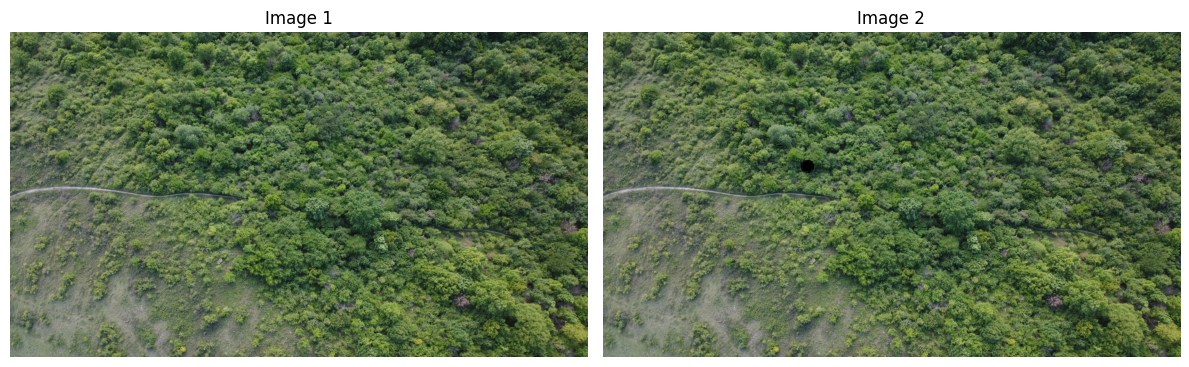

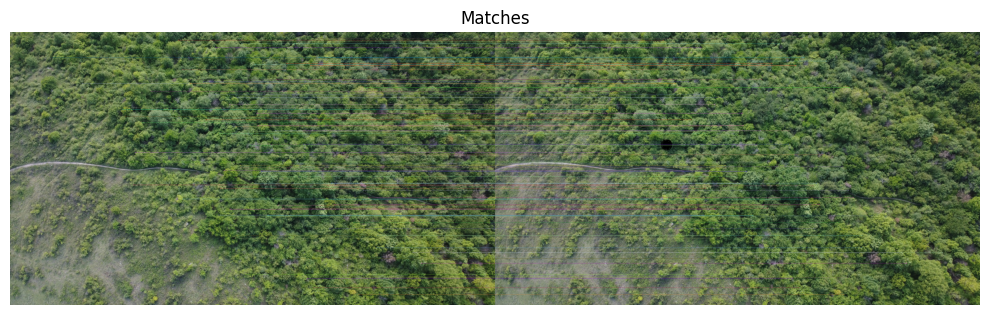

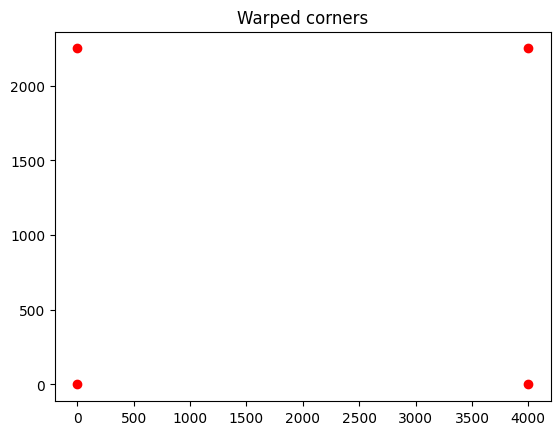

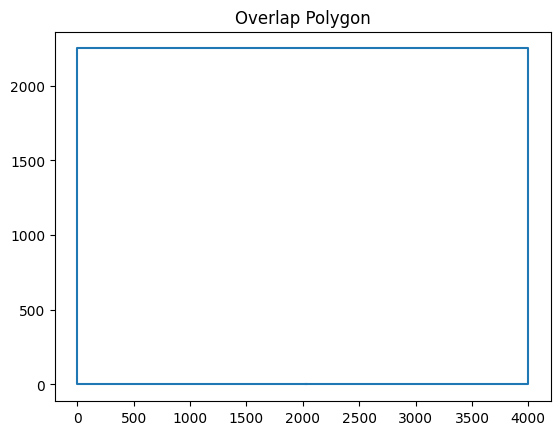

Overlap saved as 'overlap_1.png' and 'overlap_2.png' (4000x2250)


/home/epele/micromamba/envs/license/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/epele/micromamba/envs/license/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.4.1.post1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/epele/micromamba/envs/license/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/epele/micromamba/envs/license/

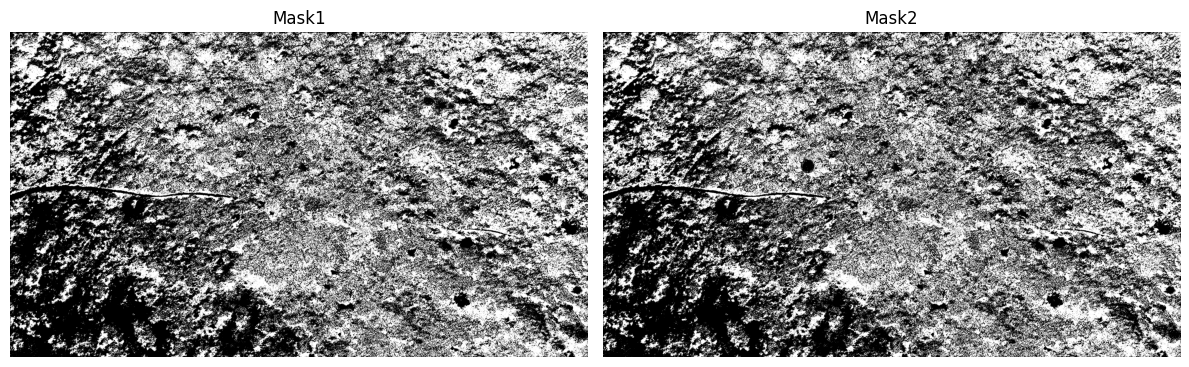

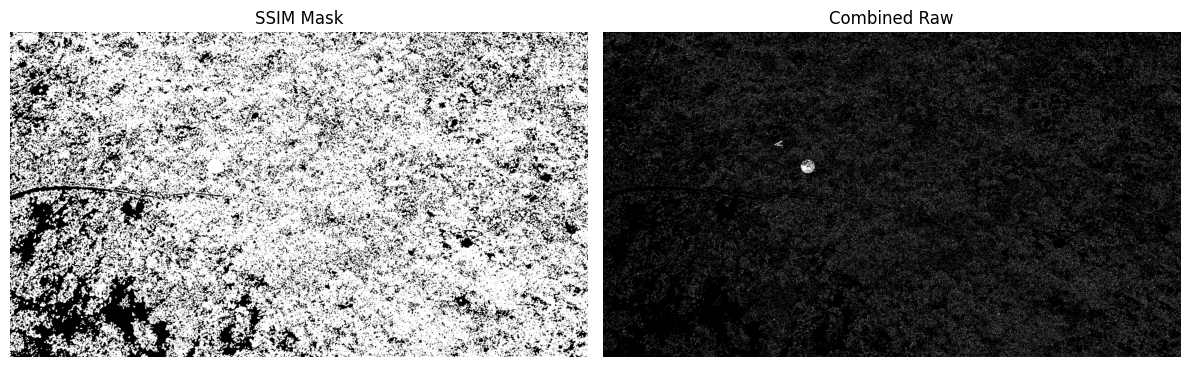

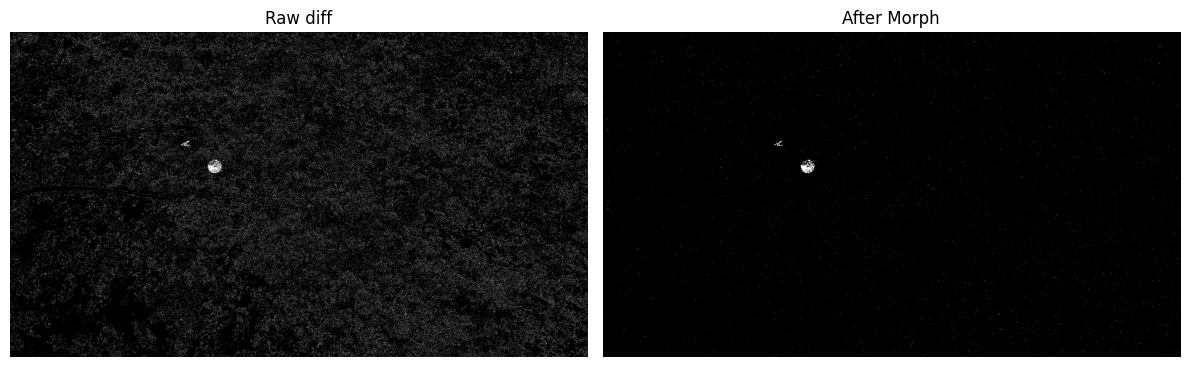

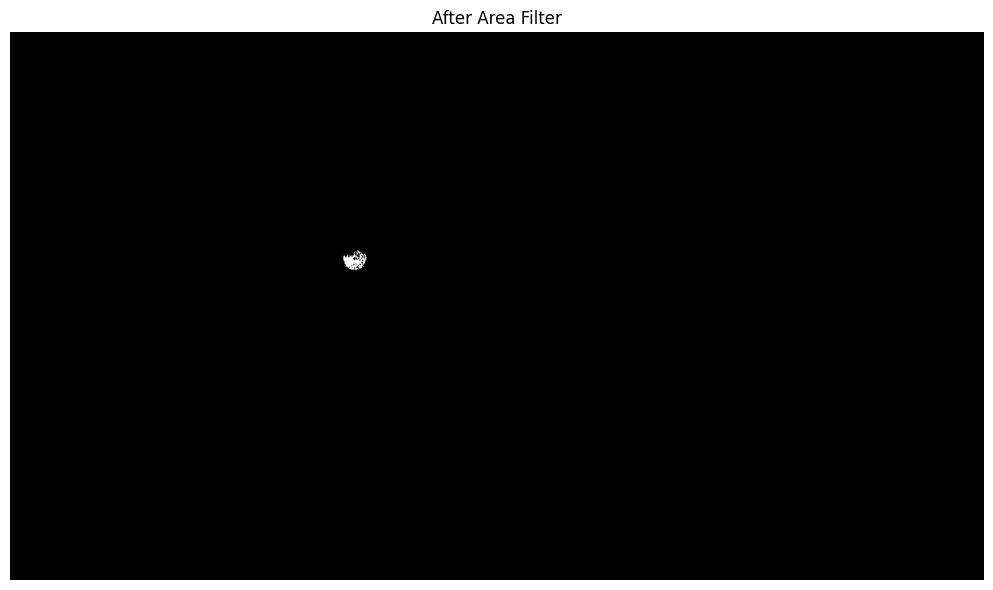

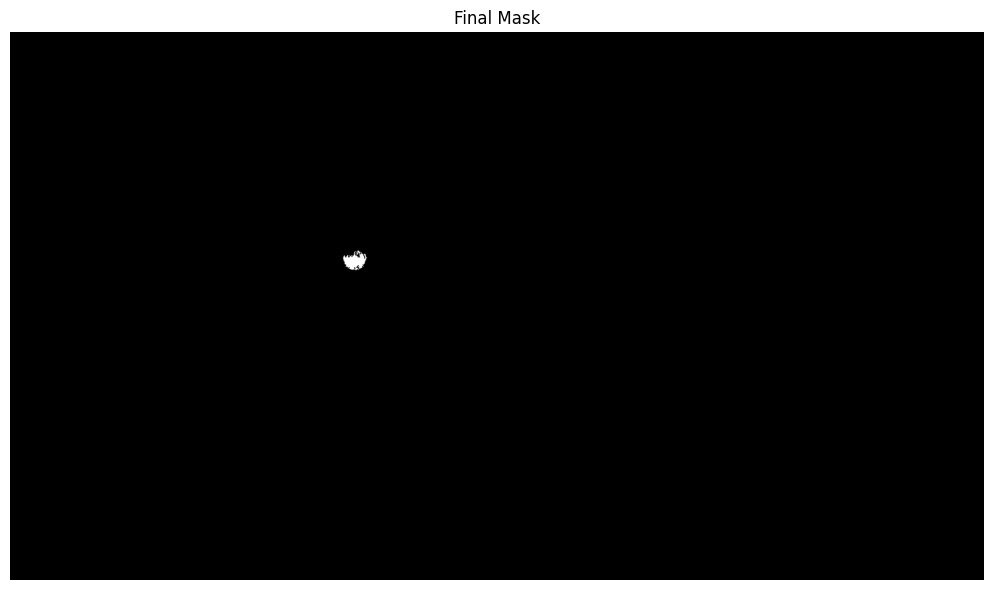

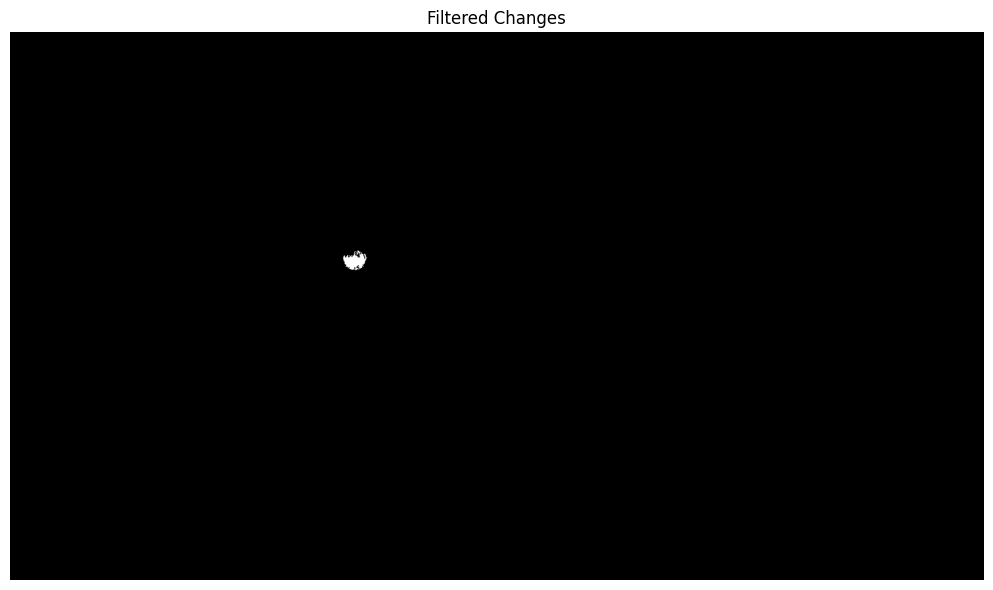

In [5]:

# Crop the overlapping region from both images
pil1, pil2 = extract_overlap(
    "raw_images/demo/test_2.JPG",
    "raw_images/demo/test_3.JPG",
    out1="overlap_1.png",
    out2="overlap_2.png", 
    debug=True
)

# Run Detectree (binary masks)
classifier = dtr.Classifier()
m1 = classifier.predict_img("overlap_1.png")
m2 = classifier.predict_img("overlap_2.png")

show_imgs([m1, m2], titles=["Mask1","Mask2"], cmap='gray')

# Raw difference mask
diff = m2.astype(np.int8) - m1.astype(np.int8)
raw_diff = (diff != 0).astype(np.uint8)

# SSIM Mask
m1f = m1.astype(float)
m2f = m2.astype(float)
_, s_map = ssim(m1f, m2f, full=True, data_range=1.0)
struct_mask = (s_map < 0.90).astype(np.uint8)
combined_raw = raw_diff & struct_mask

show_imgs([struct_mask, combined_raw], titles=["SSIM Mask","Combined Raw"], cmap='gray')

# Filter changes by percentage‐based min_area
final_mask = filter_changes_by_percentage(
    combined_raw,
    pct_min_area=0.001,
    ar_bounds=(0.5, 2.0),
    solidity_thresh=0.4,
    border_margin=1,
    morph_kernel_size=(3, 3),
    debug=True
)

show_imgs([final_mask], titles=["Filtered Changes"], cmap='gray')

union = np.logical_or(m1, m2).sum()
iou = final_mask.sum() / union if union > 0 else 0


